In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [ ]:
# Set up data folder
DATA = Path('/content/drive/My Drive/data')

In [ ]:
maf_file = DATA/ "TCGA.BRCA.mutect.995c0111-d90b-4140-bee7-3845436c3b42.DR-10.0.somatic.maf.gz"

pd.set_option('display.max_columns', None)
maf = pd.read_csv(DATA / maf_file, sep="\t", comment='#', low_memory=False)
maf.head()


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
0,USP24,23358,WUGSC,GRCh38,chr1,55159655,55159655,+,Missense_Mutation,SNP,T,T,C,rs150880897,by1000G;byCluster;byFrequency,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.1024A>G,p.Ile342Val,p.I342V,ENST00000294383,9/68,82,49,33,126,NaN,NaN,"USP24,missense_variant,p.I342V,ENST00000294383...",C,ENSG00000162402,ENST00000294383,Transcript,missense_variant,missense_variant,1024/10549,1024/7863,342/2620,I/V,Atc/Gtc,rs150880897,1,NaN,-1.0,USP24,HGNC,HGNC:12623,protein_coding,YES,CCDS44154.2,ENSP00000294383,Q9UPU5,NaN,UPI000059CFDE,NM_015306.2,tolerated(0.37),benign(0.003),9/68,NaN,NaN,0.0020,0.0076,0.0,NaN,0.0,0.0,0.0,0.0059,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,5.0,NaN,NaN,1,0.000715,0.002251,0.009470,0.0,0.0,0.0,0.002752,0.003676,0.0,NaN,panel_of_normals,CTGGATTGTAG,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,common_in_exac;gdc_pon,NaN,True,Unknown
1,ERICH3,127254,WUGSC,GRCh38,chr1,74571494,74571494,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4216G>A,p.Glu1406Lys,p.E1406K,ENST00000326665,14/15,86,42,44,64,NaN,NaN,"ERICH3,missense_variant,p.E1406K,ENST000003266...",T,ENSG00000178965,ENST00000326665,Transcript,missense_variant,missense_variant,4435/7159,4216/4593,1406/1530,E/K,Gag/Aag,NaN,1,NaN,-1.0,ERICH3,HGNC,HGNC:25346,protein_coding,YES,CCDS30755.1,ENSP00000322609,Q5RHP9,NaN,UPI0000237200,NM_001002912.4,deleterious(0.01),possibly_damaging(0.833),14/15,NaN,PROSITE_profiles:PS50313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,TTCCTCTACCA,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1474194,True,Unknown
2,KIF26B,55083,WUGSC,GRCh38,chr1,245419680,245419680,+,Silent,SNP,G,G,T,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.1101G>T,p.=,p.S367S,ENST00000407071,

In [ ]:
mut = maf[(maf.FILTER == "PASS")].copy()

print("{} out of {} mutations passed the filtering criteria, {:.2f}%.".format(
    len(mut), len(maf), 100 * len(mut) / len(maf)))

116693 out of 120988 mutations passed the filtering criteria, 96.45%.


Define an MMR gene set using [Kyoto Encyclopedia of Genes and Genomes (KEGG) database](https://www.genome.jp/kegg/). 

In [ ]:
#  Kyoto Encyclopedia of Genes and Genomes (KEGG) database -> KEGG pathway -> mismatch repair
mmr = ['PMS2', 'MLH1', 'MSH6', 'MSH2', 'MLH1', 'PMS2', 'MSH2', 'MSH3', 'MLH1', 
       'MLH3', 'MSH2', 'MSH3', 'RFC1', 'PCNA', 'EXO1', 'POLD1', 'POLD2','POLD3','POLD4','LIG1']

mut_mmr_loc = [x in mmr for x in mut.Hugo_Symbol]
mut_mmr = mut[mut_mmr_loc]
mut_mmr.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
1483,MLH3,27030,WUGSC,GRCh38,chr14,75049506,75049506,+,Missense_Mutation,SNP,G,G,T,novel,NaN,TCGA-BH-A2L8-01A-11D-A18P-09,TCGA-BH-A2L8-10A-01D-A18P-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,ce4179d3-b31d-4242-8ec1-f6785f9af2e1,b0e8676c-6f2d-4691-96c5-b323dded9687,c.150C>A,p.Phe50Leu,p.F50L,ENST00000355774,2/13,27,24,3,35,NaN,NaN,"MLH3,missense_variant,p.F50L,ENST00000355774,N...",T,ENSG00000119684,ENST00000355774,Transcript,missense_variant,missense_variant,366/7896,150/4362,50/1453,F/L,ttC/ttA,NaN,1,NaN,-1.0,MLH3,HGNC,HGNC:7128,protein_coding,YES,CCDS32123.1,ENSP00000348020,Q9UHC1,NaN,NaN,NM_001040108.1,deleterious(0.03),benign(0.049),2/13,NaN,Pfam_domain:PF02518;Superfamily_domains:SSF55874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,NaN,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,ACTTGGAAGGT,11ec0db5-b9df-4819-b610-2e2b788722a5,85a8276c-d322-4888-b649-e375aaf1398c,1fc01ace-df30-48b0-bb77-dc862ae9d52b,bac4b268-c781-4408-96d8-43a48fec7418,NaN,NaN,True,Unknown
2251,MLH1,4292,WUGSC,GRCh38,chr3,37004425,37004425,+,Missense_Mutation,SNP,G,G,C,rs587779005,NaN,TCGA-D8-A1XK-01A-21D-A14K-09,TCGA-D8-A1XK-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,8b704b7c-56d2-4816-8c47-055a794afb69,9f5b3aca-b473-43e0-9dc5-6339152822a5,c.331G>C,p.Ala111Pro,p.A111P,ENST00000231790,4/19,158,90,68,126,NaN,NaN,"MLH1,missense_variant,p.A111P,ENST00000231790,...",C,ENSG00000076242,ENST00000231790,Transcript,missense_variant,missense_variant,547/2752,331/2271,111/756,A/P,Gct/Cct,rs587779005,1,NaN,1.0,MLH1,HGNC,HGNC:7127,protein_coding,YES,CCDS2663.1,ENSP00000231790,P40692,NaN,UPI0000000C7E,NM_000249.3,deleterious(0),probably_damaging(1),4/19,NaN,Pfam_domain:PF02518;TIGRFAM_domain:TIGR00585;S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,uncertain_significance,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,1.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,ATGTGGCTCAT,6a1efd07-5111-4ae2-b733-0c2eca3517b6,70c1e811-e680-4389-86f6-6950ab1b0eb4,c289b430-5516-46f0-8910-55ac1cd62f2f,97943d87-fed7-4f14-a0a7-c5bfee64c392,NaN,COSM3823738,True,Unknown
2928,MLH3,27030,WUGSC,GRCh38,chr14,75049526,75049526,+,Missense_Mutation,SNP,T,T,C,NaN,NaN,TCGA-D8-A1XK-01A-21D-A14K-09,TCGA-D8-A1XK-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,8b704b7c-56d2-4816-8c47-055a794afb69,9f5b3aca-b473-43e0-9dc5-6339152822a5,c.130A>G,p.Arg44Gly,p.R44G,ENST00000355774,2/13,73,50,23,43,NaN,NaN,

Calculate the mutation load of each sample by aggregating the number of mutations in individual sample

In [ ]:
mut['Count'] = np.ones(mut.shape[0])
load = mut.groupby('Tumor_Sample_Barcode')['Count'].count().reset_index()
load.head()

,Tumor_Sample_Barcode,Count
0,TCGA-3C-AAAU-01A-11D-A41F-09,55
1,TCGA-3C-AALI-01A-11D-A41F-09,786
2,TCGA-3C-AALJ-01A-31D-A41F-09,67
3,TCGA-3C-AALK-01A-11D-A41F-09,70
4,TCGA-4H-AAAK-01A-12D-A41F-09,34


Identify the samples who have mutations in their MMR genes.

In [ ]:
load['Mutation'] = ['MMR' if x in np.array(mut_mmr.Tumor_Sample_Barcode) else 'Not_MMR' for x in load.Tumor_Sample_Barcode]
load.head()

,Tumor_Sample_Barcode,Count,Mutation
0,TCGA-3C-AAAU-01A-11D-A41F-09,55,Not_MMR
1,TCGA-3C-AALI-01A-11D-A41F-09,786,MMR
2,TCGA-3C-AALJ-01A-31D-A41F-09,67,Not_MMR
3,TCGA-3C-AALK-01A-11D-A41F-09,70,Not_MMR
4,TCGA-4H-AAAK-01A-12D-A41F-09,34,Not_MMR


Text(0, 0.5, 'log(mutation load)')

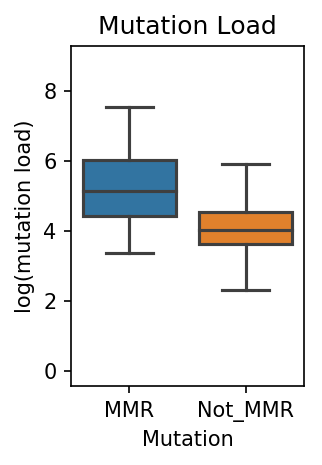

In [ ]:
load.Count = np.log(load.Count) 

x_order = ["MMR", "Not_MMR"]  
fig, ax = plt.subplots(dpi=150, figsize=(2, 3))
sns.boxplot(x = "Mutation", y = "Count", data = load, ax = ax, fliersize = 0, order = x_order)
ax.set_title("Mutation Load")
ax.set_ylabel('log(mutation load)')

In [ ]:
statistic, pvalue = ttest_ind(load[load.Mutation == 'MMR'].Count, 
                              load[load.Mutation == 'Not_MMR'].Count)

pvalue

4.530372924589139e-42

We can observe that samples with mutations in MMR genes have higher mutation loads than samples without mutations in MMR genes. MMR genes are responsible for repairing errors during DNA replication. Mutations in MMR genes can cause loss of function in DNA mismatch reparing system. This will result in more errors during DNA replication, which means more mutations. Therefore, the people with mutations in MMR genes have more mutations.